In [4]:
import pandas as pd
import numpy as np
import random
from PIL import Image
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchaudio
import torchaudio.transforms as T

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

* my matplotlib won't spot acting up so I need 2 following sells to make it work

In [2]:
x=[1,2,3]
y=[1,2,3]

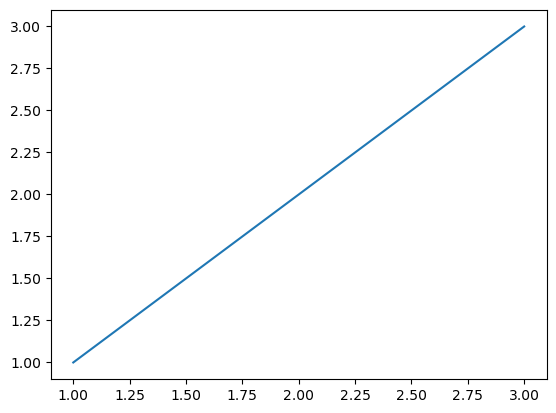

In [3]:
plt.plot(x,y)

### Looking at dataframes content and audiofiles characteristics

In [6]:
df_speech = pd.read_excel('./cleanSpeech.xlsx')
df_speech

,filename
0,./ms-snsd/CleanSpeech_training/clnsp1.wav
1,./ms-snsd/CleanSpeech_training/clnsp2.wav
2,./ms-snsd/CleanSpeech_training/clnsp3.wav
3,./ms-snsd/CleanSpeech_training/clnsp4.wav
4,./ms-snsd/CleanSpeech_training/clnsp5.wav
...,...
57,./ms-snsd/CleanSpeech_training/clnsp58.wav
58,./ms-snsd/CleanSpeech_training/clnsp59.wav
59,./ms-snsd/CleanSpeech_training/clnsp60.wav
60,./ms-snsd/CleanSpeech_training/clnsp61.wav


In [7]:
df_noise = pd.read_excel('./noises.xlsx')
df_noise

,filename
0,./ms-snsd/Noise_training/noisy1_SNRdb_0.0.wav
1,./ms-snsd/Noise_training/noisy1_SNRdb_10.0.wav
2,./ms-snsd/Noise_training/noisy1_SNRdb_20.0.wav
3,./ms-snsd/Noise_training/noisy1_SNRdb_30.0.wav
4,./ms-snsd/Noise_training/noisy2_SNRdb_0.0.wav
...,...
243,./ms-snsd/Noise_training/noisy61_SNRdb_30.0.wav
244,./ms-snsd/Noise_training/noisy62_SNRdb_0.0.wav
245,./ms-snsd/Noise_training/noisy62_SNRdb_10.0.wav
246,./ms-snsd/Noise_training/noisy62_SNRdb_20.0.wav


In [8]:
sample_wav_file = df_speech['filename'][0]
waveform, sample_rate = torchaudio.load(sample_wav_file)
print(f'Shape of the waveform: {waveform.size()}\n')
print(f'Sampling rate of the audio file: {sample_rate}')

Shape of the waveform: torch.Size([1, 163520])

Sampling rate of the audio file: 16000


In [9]:
sample_wav_file = df_noise['filename'][3]
waveform1, sample_rate1 = torchaudio.load(sample_wav_file)
print(f'Shape of the waveform: {waveform1.size()}\n')
print(f'Sampling rate of the audio file: {sample_rate1}')

Shape of the waveform: torch.Size([1, 163520])

Sampling rate of the audio file: 16000


### Function to make and plot MelSpectrogram

In [10]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto"):
    fig, axs = plt.subplots(1, 1)
    
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    
    fig.colorbar(im, ax=axs)
    plt.savefig("output.jpg")        
    plt.show()

In [11]:
n_fft = 1024
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=n_fft,
                                   hop_length=n_fft,
                                   center=True,
                                   pad_mode="reflect",
                                   power=2.0,
                                   norm='slaney',
                                   n_mels=n_mels,
                                   mel_scale="htk")

### MelSpectrogram of a clean speech

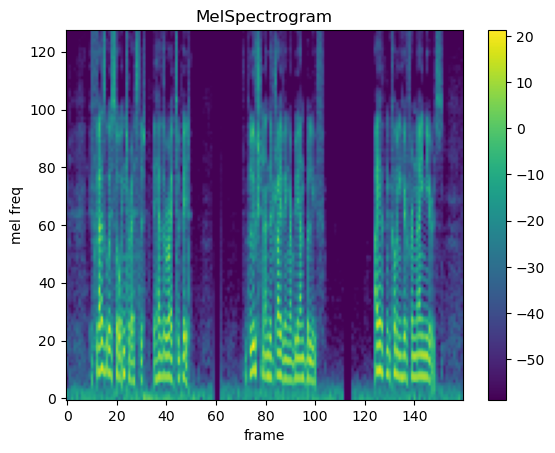

In [12]:
melspec = mel_spectrogram(waveform)
img = plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel='mel freq')
img

## MelSpec graph w/o unnecessary info

In [13]:
def plot_mel_spec_clean(spec, aspect="auto"):
    im = plt.imshow(librosa.power_to_db(spec), 
                    origin="lower", aspect=aspect)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible (False)
    
    plt.savefig("output.png", bbox_inches='tight', 
                pad_inches=0, transparent=True)  

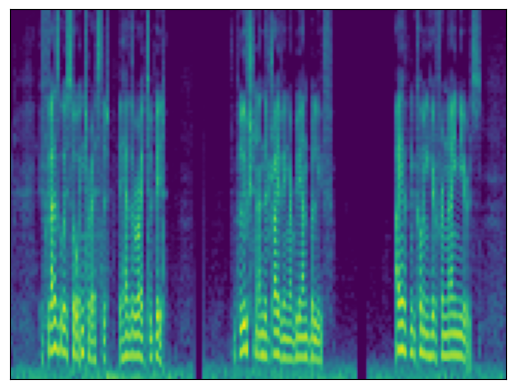

In [14]:
melspec = mel_spectrogram(waveform)
im = plot_mel_spec_clean(melspec[0])
im

### Checking dimensions placement

In [15]:
img = Image.open(r'./output.png')
print(np.array(img).shape)

(369, 496, 4)


In [16]:
def prepare_image(path):
    size = (369, 369)
    img = Image.open(path).convert('RGB').resize(size)
   
#     fig = plt.imshow(img)
#     plt.show()

    np_img = np.array(img, dtype='uint8')
    img_tens = np.transpose(np_img, (2, 1, 0))/255
    tens = torch.from_numpy(img_tens)
    
    return tens

In [17]:
l = prepare_image(r'./output.png')

In [18]:
l.shape

torch.Size([3, 369, 369])

### MelSpectrogram of a noisy speech

In [19]:
b = waveform + waveform1
b.size()

torch.Size([1, 163520])

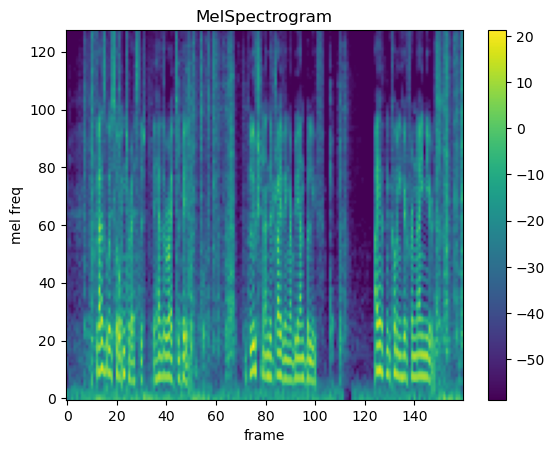

In [20]:
melspec = mel_spectrogram(b)
plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel='mel freq')

### Functions to randomly get clean or noisy speech 

In [128]:
def get_item(df):
    idx = random.randint(0, len(df)-1)
#     print(f'index {idx}')
    
    sample_wav_file = df['filename'][idx]
    wave, _ = torchaudio.load(sample_wav_file)
    
    return wave

In [56]:
def get_lucky(df_speech, df_noise):
    max_length = 254880
    label = 0
    wave_speech = get_item(df_speech)
#     print(f'wave_speech {wave_speech.size()}')
    
    if len(wave_speech[0]) < max_length:
        padding = (1, abs(max_length - len(wave_speech[0])) - 1)
        wave_speech = F.pad(wave_speech, padding, 'constant', 0)
#         print(f'wave_speech {wave_speech.size()}')
    
    luck = random.random()
    if luck >= 0.5:
        
        wave_noise = get_item(df_noise)
#         print(f'wave_noise {wave_noise.size()}')
                
        if len(wave_noise[0]) < max_length:
            padding = (1, abs(max_length - len(wave_noise[0])) - 1)
            wave_noise = F.pad(wave_noise, padding, 'constant', 0)
#             print(f'wave_noise {wave_noise.size()}')
        
        wave_out = wave_speech + wave_noise
        label = 1
        return wave_out, label
    
    else: return wave_speech, label
#         return torch.tensor(wave_speech, dtype=torch.int8), torch.tensor(label, dtype=torch.int8)

In [40]:
def get_mel_spec(wave):
    sample_rate = 16000
    n_fft = 1024
    hop_length = 512
    n_mels = 128
    size = (369, 369)

    mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                       n_fft=n_fft,
                                       hop_length=n_fft,
                                       center=True,
                                       pad_mode="reflect",
                                       power=2.0,
                                       norm='slaney',
                                       n_mels=n_mels,
                                       mel_scale="htk")

    melspec = mel_spectrogram(wave)
    img = plot_mel_spec_clean(melspec[0])
    tens = prepare_image(r'./output.png')
    
    return tens

### Checking resulting tensor out of image

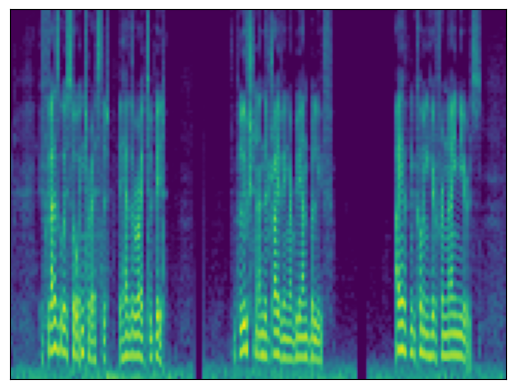

In [41]:
t = get_mel_spec(waveform)

In [42]:
t

tensor([[[0.0588, 0.0627, 0.0627,  ..., 0.0314, 0.0353, 0.0314],
         [0.2510, 0.2667, 0.2667,  ..., 0.1373, 0.1490, 0.1373],
         [0.2510, 0.2667, 0.2667,  ..., 0.1373, 0.1451, 0.1333],
         ...,
         [0.2510, 0.2667, 0.2667,  ..., 0.1294, 0.1333, 0.1255],
         [0.2510, 0.2667, 0.2667,  ..., 0.1333, 0.1373, 0.1294],
         [0.2392, 0.2549, 0.2549,  ..., 0.1373, 0.1412, 0.1333]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.1255, 0.1176, 0.1098],
         [0.0000, 0.0039, 0.0039,  ..., 0.5412, 0.5059, 0.4745],
         [0.0000, 0.0039, 0.0039,  ..., 0.5333, 0.5216, 0.4902],
         ...,
         [0.0000, 0.0039, 0.0039,  ..., 0.6275, 0.6353, 0.5961],
         [0.0000, 0.0039, 0.0039,  ..., 0.5333, 0.5255, 0.4941],
         [0.0000, 0.0000, 0.0000,  ..., 0.4902, 0.4784, 0.4510]],

        [[0.0745, 0.0784, 0.0784,  ..., 0.1294, 0.1333, 0.1255],
         [0.3098, 0.3294, 0.3294,  ..., 0.5569, 0.5608, 0.5294],
         [0.3098, 0.3294, 0.3294,  ..., 0.5529, 0.5569, 0.

### Trying for Linear NN

In [92]:
t_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(254880, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
    )
t_model.type(torch.FloatTensor)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=254880, out_features=256, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=128, out_features=2, bias=True)
  (6): Softmax(dim=1)
)

In [129]:
def train_model(model, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    
    loss_accum = 0
    correct_samples = 0
    total_samples = 0
    
    for epoch in range(num_epochs):
        model.train()
        
        x, y = get_lucky(df_speech, df_noise)
        y = torch.tensor([y])
        prediction = t_model(x)
#         print(prediction.size(), y.size())
#         print('pred', prediction)
        
        loss_value = loss(prediction, y)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
            
        _, indices = torch.max(prediction, 1)
#         print('indicex', indices)
        correct_samples += torch.sum(indices == y)
        total_samples += 1
        loss_accum += loss_value

        ave_loss = loss_accum / total_samples
        train_accuracy = float(correct_samples) / total_samples
        
        scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        print(f'Average loss: {ave_loss}, Train accuracy: {train_accuracy}')
        
    return loss_history, train_history

In [130]:
loss = nn.CrossEntropyLoss()
# .type(torch.FloatTensor)
optimizer = optim.Adam(t_model.parameters(), 
                       lr=1e-4, 
                       weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

In [132]:
loss_history, train_history = train_model(t_model, loss, 
                                          optimizer, scheduler, 10)

Average loss: 0.7267991304397583, Train accuracy: 0.0
Average loss: 0.694682240486145, Train accuracy: 0.5
Average loss: 0.7014099955558777, Train accuracy: 0.3333333333333333
Average loss: 0.7461764216423035, Train accuracy: 0.25
Average loss: 0.7285192012786865, Train accuracy: 0.4
Average loss: 0.7163393497467041, Train accuracy: 0.5
Average loss: 0.7113810181617737, Train accuracy: 0.5714285714285714
Average loss: 0.7136791348457336, Train accuracy: 0.5
Average loss: 0.7151896953582764, Train accuracy: 0.4444444444444444
Average loss: 0.7171934247016907, Train accuracy: 0.4


### Conv NN

In [21]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            nn.Flatten(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.FloatTensor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=10, bias=True)
)